In [102]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')
begin_start = time.time()

In [103]:
file = "big_df_v2.csv"  #large file for production
#file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [104]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [105]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           247144
parentItemId      3974
itemId            3515
shortDn            204
main_cat             0
sub_cat              0
catNode              0
longDn               0
categoryPath         0
name                 0
dtype: int64

In [106]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 74 categories of books.
56 categories have more than 100 books.


In [107]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [108]:
# Only keep records for top n populated categories (drop sparsely populated categories)
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

In [109]:
df.sub_cat.value_counts().tail(n=30)

Political Books                             9292
Language Arts & Disciplines Books           7501
Self-Help Books                             7103
Health & Wellness Books                     6852
Crafts & Hobbies Books                      6475
Mathematics Books                           6388
Philosophy Books                            6114
Travel Books                                5810
Reference Books                             5681
Foreign Language Study & Reference Books    5561
Teen & Young Adult Books                    5358
Cookbooks, Food & Wine                      5031
Comic Books & Graphic Novels                4710
Study Aids & Test Prep Books                3848
Humor Books                                 3492
Literature & Fiction Books                  3203
Arts & Entertainment Books                  2588
Religion & Spirituality Books               2518
Psychology & Social Science Books           2371
Science & Nature Books                      1940
Libros en Espanol   

In [110]:
df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [111]:
#R_data_for_LDA = df
#R_data_for_LDA.to_csv('private/py_export_'+file, sep='|')

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [112]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [113]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [114]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])
#stop_words.extend(['book', 'new'])

In [115]:
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Literature & Fiction Books'
 'Religion & Spirituality Books' 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Teen & Young Adult Books' 'Medical Books'
 'Self-Help Books' 'History Books' 'True Crime Books'
 'Psychology & Social Science Books' 'House, Home & Gardening Books'
 'Travel Books' 'Education Books' 'Engineering & Transportation Books'
 'Science & Nature Books' 'Language Arts & Disciplines Books' 'Law Books'
 'Foreign Language Study & Reference Books' 'Mathematics Books'
 'Political Books' 'Philosophy Books' 'Sports & Outdoor Books'
 'Language Arts & Disciplines' 'Business & Money' 'Nonfiction' 'History'
 'Law']


In [116]:
data = df.longDn.values.tolist()

In [117]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

In [118]:
data[300]

'Robust DC Comics Roster Engage in epic match ups with a massive roster of DC Comics heroes and villains including Batman Cyborg The Flash Harley Quinn Nightwing Solomon Grundy Superman and Wonder Woman Master God Like Powers Unleash each character s unique super powers with individual move sets and environmental interactions Uncontainable Battles Fight through multi tiered fighting arenas by hurling opponents through buildings and launching them off cliffs Original DC Comics Saga Set in Iconic Environments Experience an authentic DC Comics storyline created in collaboration between NetherRealm Studios DC Entertainment and writers Justin Gray and Jimmy Palmiotti Players will discover and do battle in numerous iconic locales pulled from DC Comics lore Destructive Fighter in which the World is a Weapon Experience epic battles on a massive scale as players control the most powerful beings in the universe in destructible interactive environments Destroy elements of the world and use super 

In [119]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [120]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[4]]])

In [121]:
start = time.time()
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

end = time.time()
print(end-start)

0.0009968280792236328


In [122]:
start = time.time()
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])
end = time.time()
print(end-start)

2091.160083055496


In [123]:
start = time.time()

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
end = time.time()
print(end-start)

38.41148376464844


# How many topics should we train? 

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



1072.0016548633575


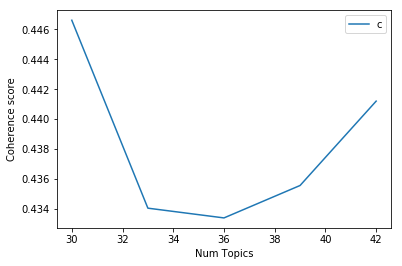

Num Topics = 30  has Coherence Value of 0.4466
Num Topics = 33  has Coherence Value of 0.4341
Num Topics = 36  has Coherence Value of 0.4334
Num Topics = 39  has Coherence Value of 0.4356
Num Topics = 42  has Coherence Value of 0.4412
1072.3761587142944


In [42]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

In [43]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



2722.557155609131


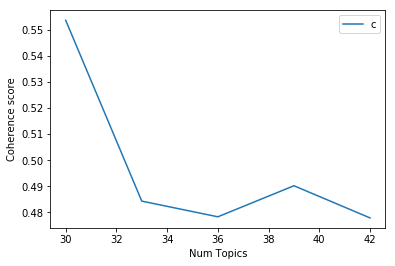

Num Topics = 30  has Coherence Value of 0.5535
Num Topics = 33  has Coherence Value of 0.4843
Num Topics = 36  has Coherence Value of 0.4783
Num Topics = 39  has Coherence Value of 0.4902
Num Topics = 42  has Coherence Value of 0.4779
2723.0563249588013


In [44]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df: 18 minutes  
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  45 minutes
> Num Topics = 30  has Coherence Value of 0.5535
> Num Topics = 33  has Coherence Value of 0.4843
> Num Topics = 36  has Coherence Value of 0.4783
> Num Topics = 39  has Coherence Value of 0.4902
> Num Topics = 42  has Coherence Value of 0.4779
      
  As expected (and unexplained) LDA Model performs better  
  than the LDA multicore model with identical parameters   



# Attempt to improve model: consider 36 topics, chunksize of 15,000 docs, and 10 passes. 
> New Best Model  
> Runtime: 8 hours (482 minutes)   
> Perplexity: -8.75203  
> Coherence Score: 0.5877  

In [94]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=36, 
                                           random_state=100,
                                           chunksize=15000,    # chunksize = number of docs to be used in each training chunk
                                           passes=10,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

1822.6068120002747

Perplexity:  -8.798481227510255

Coherence Score:  0.5689436468520527
2242.473518371582


In [95]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

487.831050157547
4836.842244386673


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     11.047266        1       1 -0.248208 -0.163162
3      10.538773        1       2 -0.288934  0.088903
34      8.037866        1       3 -0.240023  0.071508
31      5.096694        1       4 -0.155013 -0.226087
32      4.631943        1       5 -0.155759  0.089007
1       4.582232        1       6 -0.191990  0.156402
24      4.248460        1       7 -0.150935 -0.109440
15      4.225167        1       8 -0.118621 -0.252793
0       4.155436        1       9 -0.103601 -0.220712
4       4.048895        1      10 -0.082903 -0.109527
18      3.996213        1      11 -0.161768  0.225635
14      3.799229        1      12 -0.160392 -0.062293
6       3.562495        1      13 -0.177915  0.198485
33      3.047658        1      14  0.136831  0.011245
23      2.436890        1      15 -0.074995  0.050741
7       2.328447        1      16 -0.127353  0.126585
9       1.836469        1      17 -0.082074  0.067500
21      1.806971        1      18  0.024456 -0.078195
10      1.780880        1      19  0.172463  0.032598
5       1.495103        1      20  0.015758  0.169026
19      1.417339        1      21  0.043178  0.131995
13      1.229096        1      22  0.057800 -0.075297
12      1.210191        1      23  0.087411 -0.104168
30      1.124937        1      24 -0.065232 -0.070599
28      1.101566        1      25  0.131176 -0.099126
20      0.915700        1      26  0.143283 -0.031170
29      0.852822        1      27  0.154303  0.040153
26      0.842547        1      28  0.149032  0.079989
17      0.788667        1      29  0.143397 -0.066936
8       0.621979        1      30  0.195702  0.006381
27      0.560410        1      31  0.171442  0.004988
22      0.560190        1      32  0.200640  0.010890
2       0.557074        1      33  0.200531  0.005515
35      0.541532        1      34  0.182859  0.019058
16      0.529313        1      35  0.174048  0.049311
25      0.443546        1      36  0.201404  0.033589, topic_info=       Category          Freq              Term         Total  loglift  \
term                                                                     
74      Default  39273.000000             guide  39273.000000  30.0000   
375     Default  30483.000000           student  30483.000000  29.0000   
153     Default  54578.000000              life  54578.000000  28.0000   
857     Default  27630.000000          business  27630.000000  27.0000   
771     Default  34024.000000             story  34024.000000  26.0000   
553     Default  20887.000000          question  20887.000000  25.0000   
1026    Default  13933.000000             woman  13933.000000  24.0000   
841     Default  22500.000000             study  22500.000000  23.0000   
350     Default  19033.000000               man  19033.000000  22.0000   
845     Default  15745.000000              test  15745.000000  21.0000   
10026   Default  14798.000000               und  14798.000000  20.0000   
80      Default  52658.000000           include  52658.000000  19.0000   
824     Default  24935.000000          practice  24935.000000  18.0000   
126     Default  46240.000000               use  46240.000000  17.0000   
583     Default  46741.000000              work  46741.000000  16.0000   
709     Default  34186.000000             learn  34186.000000  15.0000   
523     Default  24626.000000           history  24626.000000  14.0000   
672     Default  30705.000000             write  30705.000000  13.0000   
1533    Default  15456.000000               die  15456.000000  12.0000   
10022   Default  13194.000000               der  13194.000000  11.0000   
2893    Default  10471.000000             sport  10471.000000  10.0000   
189     Default  10432.000000              game  10432.000000   9.0000   
348     Default  50341.000000              make  50341.000000   8.0000   
694     Default  11827.000000              food  11827.

# Reducing to 30 topics, 100 random state, 20k chunksize, 10 passes
> New Best Model  
> Runtime: 1 hour (4015 seconds)   
> Perplexity: -8.72211  
> Coherence Score: 0.59769  

In [96]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=20000,    # chunksize = number of docs to be used in each training chunk
                                           passes=10,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


1356.6480576992035

Perplexity:  -8.741450401829999

Coherence Score:  0.5821046867172611
1614.7293372154236


In [97]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

400.31382513046265
6852.202138185501


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     13.219747        1       1  0.217424  0.128709
8       6.566194        1       2  0.149871 -0.083116
19      5.982019        1       3  0.218236 -0.157523
16      5.910628        1       4  0.204694 -0.115548
15      5.855728        1       5  0.123799  0.258004
0       5.629588        1       6  0.079073  0.253399
4       5.028913        1       7  0.090334  0.143773
1       4.919167        1       8  0.172337 -0.168523
2       4.798533        1       9  0.177470 -0.191226
12      4.063833        1      10  0.101305  0.120838
13      3.620478        1      11  0.151671  0.042775
3       3.594596        1      12  0.104373  0.086209
24      3.309972        1      13  0.043130  0.163118
5       3.294848        1      14  0.115319 -0.048408
23      3.073788        1      15  0.076056 -0.112938
7       2.419413        1      16  0.124246 -0.129761
25      2.229306        1      17 -0.214421 -0.048951
20      2.162862        1      18 -0.037586  0.167096
10      2.059038        1      19 -0.204791 -0.045656
14      2.048648        1      20 -0.006170  0.017036
26      1.776347        1      21 -0.045729 -0.155673
29      1.742952        1      22 -0.158893 -0.031325
22      1.165740        1      23 -0.103887 -0.076443
28      1.115678        1      24 -0.200818  0.063225
18      0.891961        1      25 -0.160822 -0.055251
27      0.877246        1      26 -0.160737 -0.045979
17      0.844553        1      27 -0.180879  0.039203
6       0.642553        1      28 -0.196145  0.021546
21      0.635691        1      29 -0.219616  0.007476
9       0.519979        1      30 -0.258844 -0.046085, topic_info=       Category          Freq                  Term         Total  loglift  \
term                                                                         
583     Default  46800.000000                  work  46800.000000  30.0000   
375     Default  28857.000000               student  28857.000000  29.0000   
857     Default  22243.000000              business  22243.000000  28.0000   
1026    Default  14658.000000                 woman  14658.000000  27.0000   
74      Default  41041.000000                 guide  41041.000000  26.0000   
553     Default  19629.000000              question  19629.000000  25.0000   
771     Default  35359.000000                 story  35359.000000  24.0000   
709     Default  35406.000000                 learn  35406.000000  23.0000   
10026   Default  13355.000000                   und  13355.000000  22.0000   
153     Default  54859.000000                  life  54859.000000  21.0000   
845     Default  14336.000000                  test  14336.000000  20.0000   
1533    Default  14218.000000                   die  14218.000000  19.0000   
824     Default  23310.000000              practice  23310.000000  18.0000   
10022   Default  11883.000000                   der  11883.000000  17.0000   
841     Default  21765.000000                 study  21765.000000  16.0000   
523     Default  24389.000000               history  24389.000000  15.0000   
592     Default  20277.000000                 child  20277.000000  14.0000   
126     Default  48526.000000                   use  48526.000000  13.0000   
672     Default  31491.000000                 write  31491.000000  12.0000   
104     Default  20452.000000                  read  20452.000000  11.0000   
934     Default  19235.000000                family  19235.000000  10.0000   
700     Default  12479.000000                health  12479.000000   9.0000   
386     Default  20429.000000                  book  20429.000000   8.0000   
1227    Default  15567.000000                  part  15567.000000   7.0000   
67      Default  33735.000000                 first  33735.000000   6.0000   
80      Default  53778.000000               include  53778.000000   5.0000   
75      Default  36775.000000                

# Attempting new high score: Topics: 30, chunks: 50k, passes=20

> New Best Model? Yes  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238   

added 'new' as stopword, coherence dropped to 0.603. Decision reversed.


In [124]:
# start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=20,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

3229.780463695526

Perplexity:  -8.612855951277107

Coherence Score:  0.6238443153837738
3658.396871328354
4189.589596986771


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
8      7.682620        1       1  0.126162  0.239113
3      7.388878        1       2  0.165959  0.150445
22     7.111084        1       3  0.146858 -0.090109
10     6.815186        1       4  0.182992 -0.100506
12     5.872808        1       5  0.087727  0.151839
0      4.238932        1       6  0.149670  0.073922
16     4.234859        1       7  0.189327 -0.006779
28     4.019387        1       8  0.157192 -0.134620
11     3.931979        1       9  0.051643  0.005187
27     3.791888        1      10  0.098213 -0.186942
1      3.734640        1      11  0.034762  0.192058
17     3.716907        1      12  0.129531 -0.079662
26     3.531607        1      13  0.129676 -0.221151
4      3.527565        1      14  0.047120  0.227218
29     3.164878        1      15  0.053542 -0.013633
20     3.153921        1      16  0.127904 -0.009411
9      3.033213        1      17  0.059124  0.169573
7      3.004684        1      18 -0.249167 -0.016576
14     2.919939        1      19  0.052432 -0.238921
19     2.470753        1      20 -0.054485  0.203573
5      2.171161        1      21  0.061425 -0.008270
13     2.068492        1      22  0.077294 -0.140900
6      1.657809        1      23 -0.139351 -0.017488
23     1.454538        1      24 -0.272762 -0.032133
24     1.449684        1      25 -0.269949 -0.026736
25     1.173729        1      26 -0.169214 -0.036334
21     0.926008        1      27 -0.184771 -0.025649
15     0.716696        1      28 -0.205380 -0.002906
18     0.556126        1      29 -0.299445 -0.017824
2      0.480039        1      30 -0.284028 -0.006379, topic_info=       Category          Freq                 Term         Total  loglift  \
term                                                                        
586     Default  46352.000000                 work  46352.000000  30.0000   
376     Default  28361.000000              student  28361.000000  29.0000   
1696    Default  12906.000000                  law  12906.000000  28.0000   
76      Default  41097.000000                guide  41097.000000  27.0000   
556     Default  19509.000000             question  19509.000000  26.0000   
861     Default  23034.000000             business  23034.000000  25.0000   
11      Default  18729.000000              edition  18729.000000  24.0000   
155     Default  52982.000000                 life  52982.000000  23.0000   
595     Default  23170.000000                child  23170.000000  22.0000   
849     Default  13914.000000                 test  13914.000000  21.0000   
713     Default  35834.000000                learn  35834.000000  20.0000   
10026   Default  13146.000000                  und  13146.000000  19.0000   
526     Default  25582.000000              history  25582.000000  18.0000   
775     Default  33754.000000                story  33754.000000  17.0000   
84      Default  16522.000000             language  16522.000000  16.0000   
828     Default  24008.000000             practice  24008.000000  15.0000   
697     Default  11491.000000                 food  11491.000000  14.0000   
10022   Default  11942.000000                  der  11942.000000  13.0000   
673     Default  15074.000000                 word  15074.000000  12.0000   
389     Default  20830.000000                 book  20830.000000  11.0000   
845     Default  20941.000000                study  20941.000000  10.0000   
82      Default  54174.000000              include  54174.000000   9.0000   
1539    Default  13996.000000                  die  13996.000000   8.0000   
728     Default   8863.000000               recipe   8863.000000   7.0000   
128     Default  47977.000000                  use  47977.000000   6.0000   
169     Default  16252.000000               school  16252.000000   5.0000   
1231    Default  15822.000000                 part  15822.000000   4.0000   
77      Default  38704.00000

# Attempting new high score: Topics: 30, chunks: 50k, passes=50

> New Best Model? Yes. Marginal improvement in Coherence Score (0.0034) by increasing from 20 to 50 passes.  
> Runtime: unclocked.   
> Perplexity: -8.609     
> Coherence Score: 0.6272     

added stopword 'new' and coherence decreased to 0.6078. Decision reversed.

In [125]:
# start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


12209.38378071785

Perplexity:  -8.60946785470689

Coherence Score:  0.6272157809690225
12467.476338863373


In [100]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

10837.799659252167


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
20     9.467420        1       1  0.138624  0.226464
15     7.592996        1       2  0.150541  0.192984
11     7.216139        1       3  0.220074  0.007045
4      7.116962        1       4  0.142741 -0.026165
16     6.315588        1       5  0.203163 -0.105119
19     6.151396        1       6  0.204994 -0.083256
1      5.386608        1       7  0.175180 -0.189626
7      4.981159        1       8  0.151205 -0.205670
3      4.636549        1       9  0.133303  0.105291
8      4.328972        1      10  0.108969  0.005208
13     3.367226        1      11  0.072110  0.201950
18     3.364244        1      12  0.093062 -0.201920
12     3.287359        1      13  0.091725  0.139157
0      2.974272        1      14  0.007392  0.162003
14     2.899402        1      15  0.065514  0.075860
22     2.568656        1      16  0.123635 -0.135489
28     2.335465        1      17 -0.042930  0.170052
23     2.213763        1      18 -0.232166 -0.032268
2      2.182924        1      19  0.083821 -0.024631
9      1.838981        1      20  0.059760 -0.042063
10     1.748158        1      21 -0.220275 -0.039122
5      1.728863        1      22 -0.057711 -0.134676
29     1.387411        1      23 -0.088495  0.022815
26     0.843338        1      24 -0.248488 -0.026361
27     0.833636        1      25 -0.141850 -0.003929
6      0.776140        1      26 -0.221096  0.007771
17     0.746334        1      27 -0.220672 -0.059210
21     0.622090        1      28 -0.255622 -0.021129
24     0.593087        1      29 -0.217373  0.032398
25     0.494871        1      30 -0.279136 -0.018364, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
583    Default  46058.000000          work  46058.000000  30.0000  30.0000
592    Default  23167.000000         child  23167.000000  29.0000  29.0000
375    Default  28800.000000       student  28800.000000  28.0000  28.0000
167    Default  16531.000000        school  16531.000000  27.0000  27.0000
82     Default  16004.000000      language  16004.000000  26.0000  26.0000
857    Default  20260.000000      business  20260.000000  25.0000  25.0000
74     Default  41531.000000         guide  41531.000000  24.0000  24.0000
1691   Default  12856.000000           law  12856.000000  23.0000  23.0000
386    Default  20599.000000          book  20599.000000  22.0000  22.0000
771    Default  33602.000000         story  33602.000000  21.0000  21.0000
10026  Default  12971.000000           und  12971.000000  20.0000  20.0000
553    Default  19828.000000      question  19828.000000  19.0000  19.0000
153    Default  52804.000000          life  52804.000000  18.0000  18.0000
1533   Default  13769.000000           die  13769.000000  17.0000  17.0000
934    Default  19235.000000        family  19235.000000  16.0000  16.0000
670    Default  14511.000000          word  14511.000000  15.0000  15.0000
845    Default  14039.000000          test  14039.000000  14.0000  14.0000
10022  Default  11783.000000           der  11783.000000  13.0000  13.0000
2571   Default  17117.000000         state  17117.000000  12.0000  12.0000
824    Default  23860.000000      practice  23860.000000  11.0000  11.0000
523    Default  25633.000000       history  25633.000000  10.0000  10.0000
1026   Default  13946.000000         woman  13946.000000   9.0000   9.0000
126    Default  48798.000000           use  48798.000000   8.0000   8.0000
11     Default  18929.000000       edition  18929.000000   7.0000   7.0000
841    Default  21184.000000         study  21184.000000   6.0000   6.0000
709    Default  36136.000000         learn  36136.000000   5.0000   5.0000
1227   Default  15973.000000          part  15973.000000   4.0000   4.0000
155    Default  18055.000000           may  18055.000000   3.0000   3.0000
189    Defa

# trying same best model, separate random state (100 -> 200)
Before:  
> Runtime: 3hrs 25 minutes (12,209 seconds).   
> Perplexity: -8.609     
> Coherence Score: 0.6272    
 
After (random state changed to 200):  
> Runtime: 2hrs 15min (8,111 seconds)
> Perplexity: -8.603    
> Coherence Score: 0.611      


In [134]:
# start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=200,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


8111.531713724136

Perplexity:  -8.60297614881278

Coherence Score:  0.610765605167509
8431.883330345154


In [135]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

8880.486252784729


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
18     9.510943        1       1  0.141643 -0.264442
1      9.127538        1       2  0.214120 -0.084368
5      7.448121        1       3  0.158034  0.015566
28     7.302021        1       4  0.211452  0.205833
21     6.966243        1       5  0.195889 -0.054167
15     6.334568        1       6  0.189349  0.143452
17     5.872506        1       7  0.119581 -0.195196
16     4.732000        1       8  0.132814  0.175163
2      4.227831        1       9  0.128352  0.150476
26     3.847250        1      10  0.086446 -0.114347
14     3.407629        1      11  0.071303 -0.193543
22     3.314620        1      12  0.110051 -0.052622
4      3.306092        1      13  0.117004 -0.103675
6      2.957821        1      14  0.128863  0.191249
8      2.807771        1      15  0.130514  0.122085
25     2.373678        1      16  0.090044  0.054635
9      2.225729        1      17  0.043306 -0.028715
19     1.924335        1      18 -0.225089  0.028755
12     1.882436        1      19  0.007385 -0.074164
7      1.831456        1      20 -0.223934  0.026531
24     1.585609        1      21  0.037252  0.022684
10     1.372818        1      22 -0.095668 -0.045207
27     1.056482        1      23 -0.166884 -0.033540
29     0.884278        1      24 -0.214517  0.046863
20     0.765662        1      25 -0.189728 -0.017740
0      0.681651        1      26 -0.206281 -0.019661
11     0.629359        1      27 -0.214956  0.023070
3      0.575836        1      28 -0.238152  0.035887
13     0.530169        1      29 -0.274241  0.023023
23     0.517550        1      30 -0.263953  0.016116, topic_info=      Category          Freq                    Term         Total  loglift  \
term                                                                          
586    Default  46174.000000                    work  46174.000000  30.0000   
595    Default  23848.000000                   child  23848.000000  29.0000   
76     Default  41331.000000                   guide  41331.000000  28.0000   
84     Default  16300.000000                language  16300.000000  27.0000   
376    Default  28696.000000                 student  28696.000000  26.0000   
861    Default  21645.000000                business  21645.000000  25.0000   
1539   Default  13784.000000                     die  13784.000000  24.0000   
10026  Default  12919.000000                     und  12919.000000  23.0000   
155    Default  52200.000000                    life  52200.000000  22.0000   
10022  Default  11737.000000                     der  11737.000000  21.0000   
1696   Default  13335.000000                     law  13335.000000  20.0000   
2573   Default  17107.000000                   state  17107.000000  19.0000   
556    Default  19803.000000                question  19803.000000  18.0000   
849    Default  14220.000000                    test  14220.000000  17.0000   
828    Default  24052.000000                practice  24052.000000  16.0000   
82     Default  54473.000000                 include  54473.000000  15.0000   
243    Default  28554.000000                     get  28554.000000  14.0000   
157    Default  17952.000000                     may  17952.000000  13.0000   
673    Default  14539.000000                    word  14539.000000  12.0000   
845    Default  21123.000000                   study  21123.000000  11.0000   
132    Default  45802.000000                   world  45802.000000  10.0000   
11     Default  18862.000000                 edition  18862.000000   9.0000   
713    Default  35761.000000                   learn  35761.000000   8.0000   
1231   Default  15928.000000                    part  15928.000000   7.0000   
128    Default  48161.000000                     use  48161.000000   6.0000   
775    Default  33797.000000                   story  33797.000000   5.0000   
389    Default  20882.000000                    b

# Which description contributes the most to a topic?

In [ ]:
start = time.time()
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x:(x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output. Add original category
    contents = pd.Series(texts)
    # orig_cat = pd.Series(df.sub_cat)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
end = time.time()
print(end-start)
df_dominant_topic.head(10)


In [ ]:
start = time.time()
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

end = time.time()
print(end-start)
# Show
df_dominant_topics


# Fine tuning best model: More training docs, fewer passes.
Reducing passes from 20 -> 50 -> 12   
Increasing chucnksize from 50k to 75k  

> Improvement on Best Model? NO.   
> Runtime:  29 minutes (1790 seconds)   
> Perplexity:  -8.617      
> Coherence Score: 0.5773         

Attempt 2:  more passes and docs. 30 topics, 75k chunksize, 75 passes.
> Improvement on Best Model? No.   
> Runtime: 146 minutes (8,775 seconds)  
> Perplexity: -8.601       
> Coherence Score: 0.5895          


In [70]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=75000,    # chunksize = number of docs to be used in each training chunk
                                           passes=75,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


8775.823260068893

Perplexity:  -8.601416141500655

Coherence Score:  0.5894954149585754
9029.635265350342


In [71]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

9336.62616109848


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
22     7.845923        1       1  0.164362  0.071805
16     7.571311        1       2  0.189462 -0.064732
10     6.245324        1       3  0.170535  0.149601
3      6.066285        1       4  0.164453 -0.131971
28     5.858975        1       5  0.171902  0.196991
4      5.546209        1       6  0.127729 -0.247023
1      5.341636        1       7  0.120725 -0.239994
12     5.284297        1       8  0.118820 -0.129342
17     4.939339        1       9  0.130380  0.139052
8      4.678584        1      10  0.097848 -0.242760
27     4.214908        1      11  0.120460  0.202169
20     3.798612        1      12  0.113909 -0.102977
29     3.204321        1      13  0.083401  0.043603
11     3.076563        1      14  0.055874  0.048455
7      3.029193        1      15 -0.227023  0.007884
26     2.872478        1      16  0.081835  0.034601
9      2.860450        1      17  0.073835 -0.141930
0      2.564409        1      18  0.060014 -0.030326
15     2.503946        1      19  0.092720  0.140841
13     2.469833        1      20  0.088654  0.167908
23     1.975849        1      21 -0.252757  0.008129
25     1.842627        1      22 -0.015977  0.107778
14     1.324580        1      23 -0.073113  0.094178
19     0.943482        1      24 -0.223814 -0.099467
18     0.906516        1      25 -0.227951  0.025174
5      0.885276        1      26 -0.172122  0.010917
21     0.571364        1      27 -0.219226 -0.007222
24     0.554198        1      28 -0.256481 -0.002958
6      0.523226        1      29 -0.288358 -0.003569
2      0.500288        1      30 -0.270095 -0.004815, topic_info=       Category          Freq       Term         Total  loglift  logprob
term                                                                    
586     Default  47767.000000       work  47767.000000  30.0000  30.0000
376     Default  28884.000000    student  28884.000000  29.0000  29.0000
155     Default  56365.000000       life  56365.000000  28.0000  28.0000
84      Default  16900.000000   language  16900.000000  27.0000  27.0000
1696    Default  13419.000000        law  13419.000000  26.0000  26.0000
556     Default  19421.000000   question  19421.000000  25.0000  25.0000
76      Default  39672.000000      guide  39672.000000  24.0000  24.0000
10026   Default  13901.000000        und  13901.000000  23.0000  23.0000
595     Default  24063.000000      child  24063.000000  22.0000  22.0000
849     Default  13724.000000       test  13724.000000  21.0000  21.0000
10022   Default  12402.000000        der  12402.000000  20.0000  20.0000
775     Default  35655.000000      story  35655.000000  19.0000  19.0000
828     Default  23565.000000   practice  23565.000000  18.0000  18.0000
713     Default  36789.000000      learn  36789.000000  17.0000  17.0000
1539    Default  14654.000000        die  14654.000000  16.0000  16.0000
389     Default  20927.000000       book  20927.000000  15.0000  15.0000
82      Default  53256.000000    include  53256.000000  14.0000  14.0000
673     Default  14474.000000       word  14474.000000  13.0000  13.0000
697     Default  11060.000000       food  11060.000000  12.0000  12.0000
861     Default  20005.000000   business  20005.000000  11.0000  11.0000
845     Default  20961.000000      study  20961.000000  10.0000  10.0000
128     Default  48431.000000        use  48431.000000   9.0000   9.0000
349     Default  52342.000000       make  52342.000000   8.0000   8.0000
526     Default  25269.000000    history  25269.000000   7.0000   7.0000
703     Default  12524.000000     health  12524.000000   6.0000   6.0000
243     Default  28295.000000        get  28295.000000   5.0000   5.0000
1231    Default  15834.000000       part  15834.000000   4.0000   4.0000
3653    Default   8792.000000       exam   8792.000000   3.0000   3.0000
675     Default  30122.000000      write  30122.000000   2.0000   2.000

# Attempting new high score: Topics: 30, chunks: 35, passes=35

> New Best Model? No.  
> Runtime: 1 hr (3688 seconds)     
> Perplexity: -8.6717   
> Coherence Score: 0.5625   

In [27]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=35000,    # chunksize = number of docs to be used in each training chunk
                                           passes=35,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

3442.113005399704

Perplexity:  -8.671670944002065

Coherence Score:  0.562499034663562
3688.8340122699738
279.92552185058594


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     9.755023        1       1  0.225022 -0.103189
22     8.067950        1       2  0.176769 -0.079570
12     7.515685        1       3  0.145032  0.187209
0      6.524502        1       4  0.164038  0.140581
1      5.559953        1       5  0.124849  0.217121
17     5.497061        1       6  0.179311  0.086714
3      4.540558        1       7  0.093029  0.154230
27     4.524009        1       8  0.147101 -0.202277
8      4.444564        1       9  0.110235  0.254337
16     3.995384        1      10  0.160556 -0.052763
14     3.991405        1      11  0.128359 -0.232688
26     3.831290        1      12  0.157008 -0.203885
20     3.746266        1      13  0.172650 -0.105339
29     3.666068        1      14  0.127173 -0.057472
11     3.484769        1      15  0.117168 -0.031018
4      3.265968        1      16  0.069885  0.120481
7      2.974658        1      17 -0.184868 -0.015298
9      2.512213        1      18  0.054986  0.129235
23     2.317129        1      19 -0.206899 -0.024931
28     2.302036        1      20  0.037438 -0.161099
13     1.315048        1      21 -0.128637  0.081604
21     1.246221        1      22 -0.058317  0.015280
5      1.100085        1      23 -0.072993 -0.019202
25     0.635060        1      24 -0.227435 -0.022895
15     0.592400        1      25 -0.231733 -0.035423
6      0.580622        1      26 -0.255306 -0.007611
19     0.562275        1      27 -0.249296  0.002381
18     0.501585        1      28 -0.253754 -0.000428
24     0.484279        1      29 -0.265350 -0.018662
2      0.465934        1      30 -0.256020 -0.015423, topic_info=       Category          Freq                 Term         Total  loglift  \
term                                                                        
586     Default  45357.000000                 work  45357.000000  30.0000   
376     Default  27085.000000              student  27085.000000  29.0000   
76      Default  40543.000000                guide  40543.000000  28.0000   
155     Default  53830.000000                 life  53830.000000  27.0000   
713     Default  35928.000000                learn  35928.000000  26.0000   
10026   Default  14699.000000                  und  14699.000000  25.0000   
84      Default  19117.000000             language  19117.000000  24.0000   
11      Default  17761.000000              edition  17761.000000  23.0000   
861     Default  22418.000000             business  22418.000000  22.0000   
10022   Default  13225.000000                  der  13225.000000  21.0000   
775     Default  35702.000000                story  35702.000000  20.0000   
1539    Default  15389.000000                  die  15389.000000  19.0000   
649     Default  12148.000000              journal  12148.000000  18.0000   
169     Default  15260.000000               school  15260.000000  17.0000   
675     Default  32187.000000                write  32187.000000  16.0000   
82      Default  53837.000000              include  53837.000000  15.0000   
595     Default  21648.000000                child  21648.000000  14.0000   
556     Default  19523.000000             question  19523.000000  13.0000   
128     Default  48537.000000                  use  48537.000000  12.0000   
828     Default  23669.000000             practice  23669.000000  11.0000   
849     Default  14390.000000                 test  14390.000000  10.0000   
198     Default  14375.000000                 page  14375.000000   9.0000   
845     Default  21825.000000                study  21825.000000   8.0000   
673     Default  15906.000000                 word  15906.000000   7.0000   
77      Default  38081.000000                 help  38081.000000   6.0000   
526     Default  24330.000000              history  24330.000000   5.0000   
1696    Default  12680.000000                  law  12680.000000   4.0000   
243     Default  28149.00000

# Begin LDA Model

## 2nd best model: LdaModel, 40 topic, 100 random state, 5k chunksize, 2 passes, per_word True

In [29]:

start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)


560.8973016738892


In [30]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(17,
  '0.020*"smith" + 0.019*"film" + 0.011*"chris" + 0.010*"library" + '
  '0.009*"bob" + 0.009*"co" + 0.008*"franchise" + 0.007*"mafia" + '
  '0.006*"contract" + 0.006*"industry"'),
 (7,
  '0.042*"state" + 0.028*"imperfection" + 0.021*"may" + 0.020*"edition" + '
  '0.019*"find" + 0.019*"rare" + 0.018*"thousand" + 0.018*"original" + '
  '0.018*"preserve" + 0.018*"com"'),
 (3,
  '0.015*"henry" + 0.012*"mike" + 0.009*"senator" + 0.007*"church" + '
  '0.006*"clark" + 0.006*"islamic" + 0.005*"devil" + 0.005*"religion" + '
  '0.005*"robinson" + 0.005*"democracy"'),
 (26,
  '0.030*"horse" + 0.019*"organisation" + 0.018*"record" + 0.016*"fly" + '
  '0.016*"flight" + 0.013*"transcript" + 0.010*"batman" + '
  '0.009*"supporting_pleading" + 0.009*"plane" + 0.008*"iran"'),
 (35,
  '0.035*"art" + 0.021*"artist" + 0.017*"image" + 0.013*"world" + '
  '0.011*"include" + 0.011*"color" + 0.010*"creative" + 0.009*"photograph" + '
  '0.009*"feature" + 0.008*"museum"'),
 (27,
  '0.027*"internet" + 0.02

# Begin LDA Multicore Model  
## initial results: lower coherence score but processes twice as fast
Initial Results:   
> topics: 40, chunksize: 55k, passes=20   
>> perplexity: -8.569  
>> coherence:  0.5478   
>> time: 47 minutes (2838 seconds) 
   
Secondary Results:   
> topics: 30, chunksize: 55k, passes=20   
>> perplexity: -8.588  
>> coherence: 0.5362   
>> time: 42 minutes (2507 seconds)


In [132]:
start = time.time()

lda_multicore_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           workers=3,
                                           num_topics=30, 
                                           random_state=100,
                                           eval_every=10,     # update_every = how often the model should be updated 
                                           chunksize=55000,  # chunksize = number of docs to be used in each training chunk
                                           passes=20,        # passes = total number of training passes
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)

2489.9786388874054


In [133]:
start = time.time()
# Compute Perplexity
print('\nPerplexity: ', lda_multicore_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


Perplexity:  -8.588209017787939

Coherence Score:  0.536202097708393
412.1988625526428


In [131]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     9.130020        1       1  0.162780 -0.107583
4      8.961550        1       2  0.116891  0.201302
28     6.940021        1       3  0.135920 -0.213360
17     6.322191        1       4  0.161324 -0.058585
12     6.189198        1       5  0.103378  0.108295
22     5.692001        1       6  0.111958 -0.109281
27     5.522242        1       7  0.086013 -0.238000
3      5.453593        1       8  0.130642  0.076227
20     5.039793        1       9  0.093218  0.028715
29     4.349758        1      10  0.047409 -0.023892
19     4.219018        1      11  0.075351  0.196132
0      3.940894        1      12  0.117896 -0.003932
7      3.059260        1      13 -0.294949 -0.063661
14     2.851578        1      14 -0.005954 -0.074840
1      2.577109        1      15  0.078248  0.143370
26     2.566263        1      16  0.057770 -0.020294
13     2.488815        1      17  0.079034 -0.178057
9      2.453072        1      18  0.080720  0.154274
23     1.984148        1      19 -0.339319 -0.055425
15     1.702588        1      20  0.032050 -0.129008
25     1.474553        1      21  0.008120 -0.116579
24     1.206835        1      22 -0.063337  0.012729
18     0.951106        1      23 -0.304200 -0.066231
8      0.945380        1      24 -0.029949  0.186296
11     0.895091        1      25 -0.025533  0.107474
5      0.696719        1      26 -0.170228 -0.008904
16     0.676438        1      27 -0.052606  0.121164
21     0.617796        1      28 -0.117762  0.008028
6      0.552952        1      29 -0.203143  0.073007
2      0.540019        1      30 -0.071741  0.050619, topic_info=      Category          Freq                Term         Total  loglift  \
term                                                                      
586    Default  45966.000000                work  45966.000000  30.0000   
376    Default  28457.000000             student  28457.000000  29.0000   
1696   Default  12427.000000                 law  12427.000000  28.0000   
76     Default  40588.000000               guide  40588.000000  27.0000   
10026  Default  12873.000000                 und  12873.000000  26.0000   
155    Default  56059.000000                life  56059.000000  25.0000   
849    Default  14321.000000                test  14321.000000  24.0000   
10022  Default  11593.000000                 der  11593.000000  23.0000   
861    Default  22852.000000            business  22852.000000  22.0000   
556    Default  19348.000000            question  19348.000000  21.0000   
828    Default  23679.000000            practice  23679.000000  20.0000   
1539   Default  13864.000000                 die  13864.000000  19.0000   
697    Default  11490.000000                food  11490.000000  18.0000   
845    Default  21375.000000               study  21375.000000  17.0000   
775    Default  34322.000000               story  34322.000000  16.0000   
526    Default  26555.000000             history  26555.000000  15.0000   
728    Default   9216.000000              recipe   9216.000000  14.0000   
82     Default  54166.000000             include  54166.000000  13.0000   
3653   Default   8575.000000                exam   8575.000000  12.0000   
2249   Default   8300.000000                 map   8300.000000  11.0000   
595    Default  23051.000000               child  23051.000000  10.0000   
132    Default  45848.000000               world  45848.000000   9.0000   
673    Default  13976.000000                word  13976.000000   8.0000   
703    Default  10964.000000              health  10964.000000   7.0000   
389    Default  21574.000000                book  21574.000000   6.0000   
77     Default  39515.000000                help  39515.000000   5.0000   
2894   Default   8810.000000               sport   8810.000000   4.0000   
2425   Default   7214.000000                  la   7214.000000   3.0000   
133    Defa

In [34]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

[(26,
  '0.013*"math" + 0.010*"record" + 0.009*"transcript" + 0.008*"grade" + '
  '0.007*"common_core" + 0.006*"supporting_pleading" + 0.005*"standard" + '
  '0.005*"dementia" + 0.004*"curriculum" + 0.004*"school"'),
 (10,
  '0.014*"business" + 0.012*"use" + 0.011*"guide" + 0.008*"step" + '
  '0.008*"make" + 0.007*"learn" + 0.007*"need" + 0.007*"new" + 0.006*"help" + '
  '0.006*"work"'),
 (19,
  '0.006*"et" + 0.004*"test_taker" + 0.004*"film" + 0.004*"elle" + 0.004*"che" '
  '+ 0.003*"pour" + 0.003*"histoire" + 0.003*"ce" + 0.003*"macroeconomic" + '
  '0.003*"sont"'),
 (25,
  '0.018*"horse" + 0.011*"paperback" + 0.010*"insurance" + 0.007*"bitcoin" + '
  '0.005*"security" + 0.004*"isbn" + 0.004*"house" + 0.004*"trust" + '
  '0.004*"include" + 0.004*"information"'),
 (32,
  '0.014*"part" + 0.012*"publish" + 0.010*"may" + 0.010*"imperfection" + '
  '0.009*"work" + 0.009*"print" + 0.008*"introduce" + 0.008*"believe" + '
  '0.008*"american" + 0.008*"reproduction"'),
 (8,
  '0.009*"game" + 0

In [36]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

[(2,
  '0.053*"sport" + 0.014*"training" + 0.014*"athlete" + 0.010*"player" + '
  '0.008*"soccer" + 0.008*"baseball" + 0.007*"world" + 0.006*"coach" + '
  '0.006*"fan" + 0.006*"game"'),
 (31,
  '0.012*"application" + 0.007*"batman" + 0.006*"bible" + 0.006*"new" + '
  '0.006*"code" + 0.006*"datum" + 0.006*"language" + 0.005*"sale" + '
  '0.005*"programming" + 0.004*"algorithm"'),
 (20,
  '0.014*"get" + 0.014*"learn" + 0.012*"read" + 0.012*"make" + 0.011*"child" + '
  '0.009*"help" + 0.008*"time" + 0.008*"good" + 0.008*"book" + 0.007*"want"'),
 (0,
  '0.027*"life" + 0.010*"get" + 0.009*"love" + 0.009*"find" + 0.008*"make" + '
  '0.007*"way" + 0.007*"know" + 0.007*"write" + 0.007*"go" + 0.006*"want"'),
 (33,
  '0.013*"comic" + 0.013*"yoga" + 0.013*"hardcover" + 0.008*"golf" + '
  '0.006*"series" + 0.005*"feature" + 0.005*"new" + 0.005*"child" + '
  '0.005*"include" + 0.005*"first"'),
 (14,
  '0.028*"clinical" + 0.025*"food" + 0.021*"patient" + 0.014*"disease" + '
  '0.011*"treatment" + 0.

# LDA Multicore model approach #2, fewer categories  
## Initial Result: No improvement.

In [38]:
start = time.time()
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           eval_every=1,      # update_every = how often the model should be updated 
                                           chunksize=10000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           per_word_topics=True)
end = time.time()
print(end-start)

208.51714754104614


In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.991759137108872

Coherence Score:  0.4200400745759138


In [40]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)

end = time.time()
print(end-start)
vis

449.26842761039734


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      8.683796        1       1 -0.004102  0.126211
22     8.398088        1       2  0.039298 -0.031886
12     8.248659        1       3  0.030433  0.043349
28     7.416761        1       4  0.065444 -0.090883
10     7.194577        1       5  0.055826 -0.048042
3      5.998231        1       6  0.023121  0.046246
17     5.949640        1       7  0.044940  0.001525
4      5.879297        1       8 -0.000461  0.124308
27     3.768679        1       9  0.018820 -0.089680
7      3.313036        1      10 -0.346888 -0.039897
9      3.137999        1      11  0.008577  0.071791
23     2.799010        1      12 -0.031766 -0.130712
13     2.493104        1      13  0.032216 -0.017212
20     2.229821        1      14  0.010815  0.002447
15     2.166175        1      15  0.026539 -0.024656
29     1.975405        1      16  0.009711 -0.016500
19     1.904519        1      17 -0.013781  0.078805
0      1.895702        1      18  0.025900  0.006843
16     1.863884        1      19  0.014225  0.021299
8      1.782212        1      20 -0.033373  0.057072
6      1.767625        1      21 -0.017699 -0.001744
18     1.562499        1      22 -0.028464  0.088712
5      1.551374        1      23  0.022659  0.000172
25     1.438302        1      24  0.027382 -0.030994
14     1.381868        1      25  0.017654 -0.045587
24     1.231329        1      26  0.013578 -0.044602
11     1.062542        1      27  0.015281 -0.004842
26     1.015073        1      28  0.021305 -0.032542
21     0.987633        1      29 -0.019688 -0.009174
2      0.903153        1      30 -0.027499 -0.009828, topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
10026  Default  13434.000000        und  13434.000000  30.0000  30.0000
10022  Default  12163.000000        der  12163.000000  29.0000  29.0000
1539   Default  13957.000000        die  13957.000000  28.0000  28.0000
586    Default  46161.000000       work  46161.000000  27.0000  27.0000
82     Default  52684.000000    include  52684.000000  26.0000  26.0000
128    Default  49407.000000        use  49407.000000  25.0000  25.0000
376    Default  30265.000000    student  30265.000000  24.0000  24.0000
713    Default  37197.000000      learn  37197.000000  23.0000  23.0000
76     Default  38956.000000      guide  38956.000000  22.0000  22.0000
22     Default  56728.000000        new  56728.000000  21.0000  21.0000
349    Default  54331.000000       make  54331.000000  20.0000  20.0000
155    Default  55696.000000       life  55696.000000  19.0000  19.0000
595    Default  26317.000000      child  26317.000000  18.0000  18.0000
775    Default  37915.000000      story  37915.000000  17.0000  17.0000
77     Default  38909.000000       help  38909.000000  16.0000  16.0000
84     Default  15984.000000   language  15984.000000  15.0000  15.0000
849    Default  12124.000000       test  12124.000000  14.0000  14.0000
828    Default  23095.000000   practice  23095.000000  13.0000  13.0000
3653   Default   7223.000000       exam   7223.000000  12.0000  12.0000
556    Default  17578.000000   question  17578.000000  11.0000  11.0000
132    Default  45992.000000      world  45992.000000  10.0000  10.0000
673    Default  13437.000000       word  13437.000000   9.0000   9.0000
2425   Default   6546.000000         la   6546.000000   8.0000   8.0000
845    Default  20092.000000      study  20092.000000   7.0000   7.0000
724    Default  33272.000000    provide  33272.000000   6.0000   6.0000
861    Default  24954.000000   business  24954.000000   5.0000   5.0000
697    Default  10351.000000       food  10351.000000   4.0000   4.0000
121    Default  44131.000000       time  44131.000000   3.0000   3.0000
169    Default  17124.000000     school  17124.000000   2.0000   2.0000
351    Default  17236.000000 

In [45]:
- intentional fail to prevent subsequent code to run -
fail.

SyntaxError: invalid syntax (<ipython-input-45-76a76cdb656f>, line 1)

# Begin LDA Mallet
### troubleshooting:
> https://searchcode.com/codesearch/view/92751630/ - code  
> https://github.com/RaRe-Technologies/gensim/issues/818 - bug identified?   

In [ ]:
from gensim.models.wrappers import LdaMallet

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'mallet-2.0.8/bin/mallet' 

In [ ]:
ldamallet = gensim.models.wrappers.ldamallet.LdaMallet('mallet_2.0.8/bin/mallet', corpus=corpus, num_topics=40, id2word=id2word, workers=3)

In [ ]:
#redo of LDA model

start = time.time()
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

In [ ]:
#redo of LDA multicore model. Should be same as above

start = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis